In [1]:
!pip install pot
!pip install torch
!pip install geomloss
!pip install wget


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

from geomloss import SamplesLoss

import ot

import os
import pickle as pkl
import copy

from sklearn.preprocessing import scale
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from utils import *
from SoftImpute import softimpute, cv_softimpute
from DataSetLoader import dataset_loader, ground_truth
from Experimental_Sinkhorn import Sinkhorn
from Loss_Calculation import Loss_Calculation
from RR_imputer import RRimputer
import matplotlib.pyplot as plt

import argparse
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

torch.set_default_tensor_type('torch.DoubleTensor')

c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [3]:
from sklearn.datasets import load_wine
ground_truth_numpy = (load_wine()['data'])

In [4]:
Xy = {}
with open(r'C:\Users\zhossai3\Desktop\My code\OT+Fairness\Data\portugal student performance dataset\P_Student_Performance_Data.csv', 'rb') as f:
        df = pd.read_csv(f, delimiter=',', header = 0)
        Xy['data'] = df.values[:, :-1].astype('float')
        Xy['target'] =  df.values[:, -1]

In [5]:
#ground_truth_numpy = (Xy['data'])
print(type(ground_truth_numpy))

<class 'numpy.ndarray'>


In [6]:
print(type(ground_truth_numpy))
print(np.max(ground_truth_numpy))
print(np.min(ground_truth_numpy))
print(np.mean(ground_truth_numpy))
print(np.median(ground_truth_numpy))
print(np.std(ground_truth_numpy))
print(ground_truth_numpy.shape)
np.isnan(ground_truth_numpy).sum()

<class 'numpy.ndarray'>
1680.0
0.13
69.13366292091617
2.685
215.74620420485243
(178, 13)


np.int64(0)

In [7]:
type(ground_truth_numpy)

numpy.ndarray

In [8]:
ground_truth = torch.from_numpy(ground_truth_numpy)

In [9]:
print(ground_truth)

tensor([[1.4230e+01, 1.7100e+00, 2.4300e+00,  ..., 1.0400e+00, 3.9200e+00,
         1.0650e+03],
        [1.3200e+01, 1.7800e+00, 2.1400e+00,  ..., 1.0500e+00, 3.4000e+00,
         1.0500e+03],
        [1.3160e+01, 2.3600e+00, 2.6700e+00,  ..., 1.0300e+00, 3.1700e+00,
         1.1850e+03],
        ...,
        [1.3270e+01, 4.2800e+00, 2.2600e+00,  ..., 5.9000e-01, 1.5600e+00,
         8.3500e+02],
        [1.3170e+01, 2.5900e+00, 2.3700e+00,  ..., 6.0000e-01, 1.6200e+00,
         8.4000e+02],
        [1.4130e+01, 4.1000e+00, 2.7400e+00,  ..., 6.1000e-01, 1.6000e+00,
         5.6000e+02]])


In [10]:
#30% MCAR
np.random.seed(42)

p_macr30 = 0.3


mask_mcar30 = np.random.rand(*ground_truth.shape) < p_macr30  # True for missing values, false for others
data_mcar30 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar30[mask_mcar30] = np.nan

# Convert to a torch tensor
data_mcar30 = torch.from_numpy(data_mcar30)

# Calculate the percentage of missing values
missing_values_mcar30 = torch.isnan(data_mcar30)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar30 = torch.sum(missing_values_mcar30).item() / data_mcar30.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar30:.2f}%")

Percentage of missing values: 30.73%


In [11]:
data_mcar30

tensor([[1.4230e+01, 1.7100e+00, 2.4300e+00,  ...,        nan, 3.9200e+00,
         1.0650e+03],
        [       nan,        nan,        nan,  ..., 1.0500e+00, 3.4000e+00,
         1.0500e+03],
        [       nan, 2.3600e+00, 2.6700e+00,  ..., 1.0300e+00,        nan,
         1.1850e+03],
        ...,
        [1.3270e+01, 4.2800e+00, 2.2600e+00,  ...,        nan, 1.5600e+00,
         8.3500e+02],
        [1.3170e+01,        nan, 2.3700e+00,  ...,        nan, 1.6200e+00,
         8.4000e+02],
        [1.4130e+01, 4.1000e+00,        nan,  ..., 6.1000e-01, 1.6000e+00,
         5.6000e+02]])

In [12]:
#30% MAR
np.random.seed(42)
torch.manual_seed(42)
mask_mar30, missing_ind_mar= MAR_mask(ground_truth_numpy, 0.65, 0.55)
data_mar30 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mar30[mask_mar30] = np.nan

# Convert to a torch tensor
data_mar30 = torch.from_numpy(data_mar30)

# Calculate the percentage of missing values
missing_values_mar30 = torch.isnan(data_mar30)  
missing_percentage_mar30 = torch.sum(missing_values_mar30).item() / data_mar30.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mar30:.2f}%")

Percentage of missing values: 30.25%


In [13]:
print(data_mar30)

tensor([[14.2300,  1.7100,  2.4300,  ...,     nan,  3.9200,     nan],
        [13.2000,  1.7800,  2.1400,  ...,     nan,  3.4000,     nan],
        [13.1600,  2.3600,  2.6700,  ...,     nan,  3.1700,     nan],
        ...,
        [13.2700,  4.2800,  2.2600,  ...,     nan,  1.5600,     nan],
        [13.1700,  2.5900,  2.3700,  ...,  0.6000,  1.6200,     nan],
        [14.1300,  4.1000,  2.7400,  ...,  0.6100,  1.6000,     nan]])


In [14]:
#30% MNAR
np.random.seed(42)
torch.manual_seed(42)
mask_mnar30= MNAR_mask_quantiles(ground_truth_numpy, 0.65, 0.55, 0.5)
data_mnar30 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mnar30[mask_mnar30] = np.nan

# Convert to a torch tensor
data_mnar30 = torch.from_numpy(data_mnar30)

# Calculate the percentage of missing values
missing_values_mnar30 = torch.isnan(data_mnar30)  
missing_percentage_mnar30 = torch.sum(missing_values_mnar30).item() / data_mnar30.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mnar30:.2f}%")

Percentage of missing values: 30.90%


In [15]:
data_mnar30

tensor([[       nan, 1.7100e+00,        nan,  ..., 1.0400e+00,        nan,
         1.0650e+03],
        [       nan, 1.7800e+00,        nan,  ..., 1.0500e+00, 3.4000e+00,
         1.0500e+03],
        [       nan, 2.3600e+00, 2.6700e+00,  ..., 1.0300e+00, 3.1700e+00,
         1.1850e+03],
        ...,
        [       nan, 4.2800e+00,        nan,  ..., 5.9000e-01,        nan,
         8.3500e+02],
        [1.3170e+01, 2.5900e+00,        nan,  ..., 6.0000e-01,        nan,
         8.4000e+02],
        [1.4130e+01, 4.1000e+00,        nan,  ..., 6.1000e-01,        nan,
         5.6000e+02]])

In [16]:
#sinkhorn 30% mcar
n_mcar30, d_mcar30 = data_mcar30.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar30 = pick_epsilon(data_mcar30)
print(epsilon_mcar30)

sk_imputer_mcar30 = Sinkhorn(eps=epsilon_mcar30, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar30, sk_maes30mcar, sk_rmses30mcar,imps_mean_mcar30,imps_mcar30,loss_history_mcar30,sk_imp_mcar30_mean,loss_vision_mcar30= sk_imputer_mcar30.fit_transform(data_mcar30, verbose=True, report_interval=500, X_true=ground_truth)
#using numpy version of data
sk_imp_mcar30_numpy = sk_imp_mcar30.detach().cpu().numpy()

sk_mae_mcar30 = MAE(sk_imp_mcar30_numpy,ground_truth_numpy ,mask_mcar30)
sk_rmse_mcar30 = RMSE(sk_imp_mcar30_numpy, ground_truth_numpy,mask_mcar30)
print(sk_mae_mcar30,sk_rmse_mcar30)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.


1446.29981107246


INFO:root:batchsize = 64, epsilon = 1446.2998
INFO:root:Iteration 0:	 Loss: 156.1835	 Validation MAE: 22.4227	RMSE: 87.1674
INFO:root:Iteration 500:	 Loss: 1453.9987	 Validation MAE: 22.4287	RMSE: 87.1601
INFO:root:Iteration 1000:	 Loss: 1305.2482	 Validation MAE: 22.4443	RMSE: 87.1608
INFO:root:Iteration 1500:	 Loss: 2335.0887	 Validation MAE: 22.4347	RMSE: 87.1604


22.427233927877374 87.16512353805035


In [17]:
#sinkhorn 30% mar
n_mar30, d_mar30 = data_mar30.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mar30 = pick_epsilon(data_mar30)
print(epsilon_mar30)

sk_imputer_mar30 = Sinkhorn(eps=epsilon_mar30, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mar30, sk_maes30mar, sk_rmses30mar,imps_mean_mar30,imps_mar30,loss_history_mar30, sk_imp_mar30_mean,loss_vision_mar30= sk_imputer_mar30.fit_transform(data_mar30, verbose=True, report_interval=500, X_true=ground_truth)
#using numpy version of data
sk_imp_mar30_numpy = sk_imp_mar30.detach().cpu().numpy()

sk_mae_mar30 = MAE(sk_imp_mar30_numpy,ground_truth_numpy ,mask_mar30)
sk_rmse_mar30 = RMSE(sk_imp_mar30_numpy, ground_truth_numpy,mask_mar30)
print(sk_mae_mar30,sk_rmse_mar30)    

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 65.3869
INFO:root:Iteration 0:	 Loss: 3186.0716	 Validation MAE: 43.8510	RMSE: 129.8376


65.38687686682168


INFO:root:Iteration 500:	 Loss: 12773.6736	 Validation MAE: 43.8213	RMSE: 129.7507
INFO:root:Iteration 1000:	 Loss: 4682.6327	 Validation MAE: 43.8079	RMSE: 129.6794
INFO:root:Iteration 1500:	 Loss: 2582.1106	 Validation MAE: 43.7836	RMSE: 129.6167


43.78060391115249 129.56771133726463


In [18]:
#sinkhorn 30% mar
n_mnar30, d_mnar30 = data_mnar30.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mnar30 = pick_epsilon(data_mnar30)
print(epsilon_mnar30)

sk_imputer_mnar30 = Sinkhorn(eps=epsilon_mnar30, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mnar30, sk_maes30mnar, sk_rmses30mnar,imps_mean_mnar30,imps_mnar30,loss_history_mnar30, sk_imp_mnar30_mean,loss_vision_mnar30= sk_imputer_mnar30.fit_transform(data_mnar30, verbose=True, report_interval=500, X_true=ground_truth)
#using numpy version of data
sk_imp_mnar30_numpy = sk_imp_mnar30.detach().cpu().numpy()

sk_mae_mnar30 = MAE(sk_imp_mnar30_numpy,ground_truth_numpy ,mask_mnar30)
sk_rmse_mnar30 = RMSE(sk_imp_mnar30_numpy, ground_truth_numpy,mask_mnar30)
print(sk_mae_mnar30,sk_rmse_mnar30)    

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 1990.5617
INFO:root:Iteration 0:	 Loss: 107.3869	 Validation MAE: 0.7234	RMSE: 1.0989


1990.5617265908304


INFO:root:Iteration 500:	 Loss: 426.8147	 Validation MAE: 0.7266	RMSE: 1.0972
INFO:root:Iteration 1000:	 Loss: 1632.5861	 Validation MAE: 0.7292	RMSE: 1.1005
INFO:root:Iteration 1500:	 Loss: 242.8857	 Validation MAE: 0.7418	RMSE: 1.1090


0.7240037027596128 1.0978649385844477


In [19]:
imps_mcar30.values

<function Tensor.values>

In [20]:
similarity_mcar30 = imps_mean_mnar30 == imps_mnar30.detach()
print(similarity_mcar30)

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

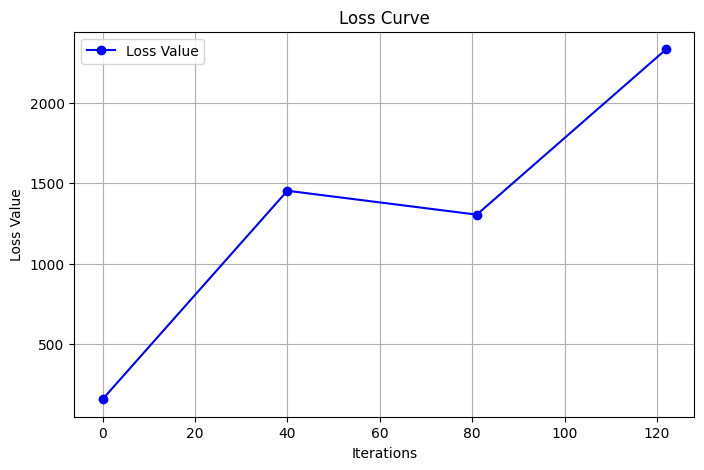

In [21]:
# Convert the list of losses to a NumPy array

iterations = np.linspace(0, 2000, 50).astype(int)



loss_values = loss_vision_mcar30


# Assuming cmi_penalty_history is also a list, convert it to a NumPy array
#cmi_penalty_history_numpy = np.array(cmi_penalty_history)

# Total loss calculation
#total_loss = sk_loss_mcar30_numpy + cmi_penalty_history_numpy
if len(loss_values) > len(iterations):
    loss_values = loss_values[:len(iterations)]
elif len(loss_values) < len(iterations):
    iterations = iterations[:len(loss_values)]



# Plotting
plt.figure(figsize=(8, 5))
plt.plot(iterations, loss_values, color='b', linestyle='-', marker='o', label="Loss Value")
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



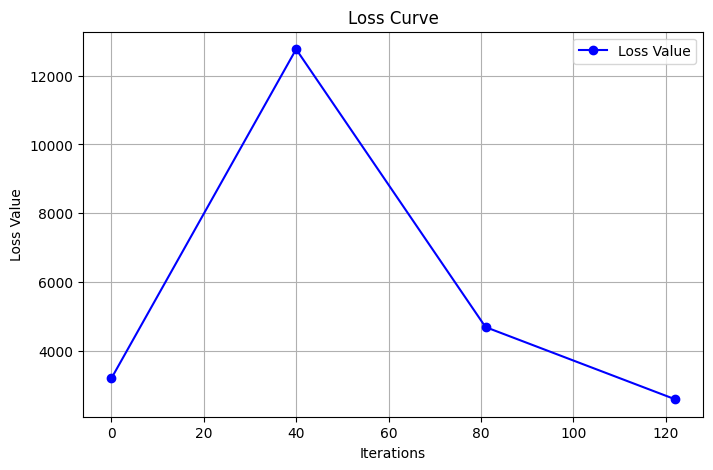

In [22]:
# Convert the list of losses to a NumPy array

iterations = np.linspace(0, 2000, 50).astype(int)



loss_values = loss_vision_mar30


# Assuming cmi_penalty_history is also a list, convert it to a NumPy array
#cmi_penalty_history_numpy = np.array(cmi_penalty_history)

# Total loss calculation
#total_loss = sk_loss_mcar30_numpy + cmi_penalty_history_numpy
if len(loss_values) > len(iterations):
    loss_values = loss_values[:len(iterations)]
elif len(loss_values) < len(iterations):
    iterations = iterations[:len(loss_values)]



# Plotting
plt.figure(figsize=(8, 5))
plt.plot(iterations, loss_values, color='b', linestyle='-', marker='o', label="Loss Value")
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



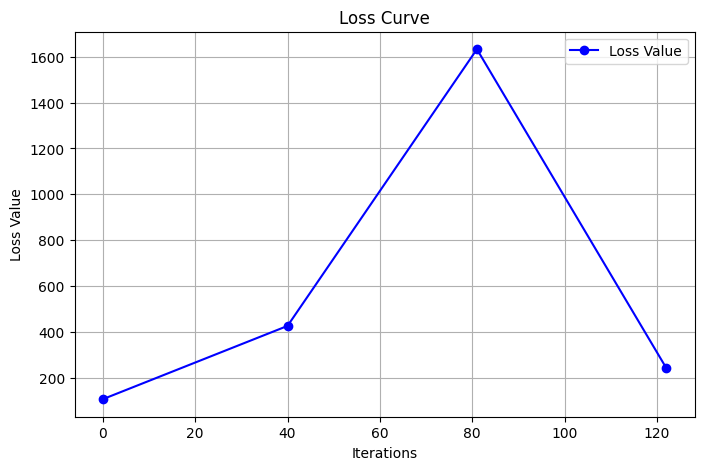

In [23]:
# Convert the list of losses to a NumPy array

iterations = np.linspace(0, 2000, 50).astype(int)



loss_values = loss_vision_mnar30


# Assuming cmi_penalty_history is also a list, convert it to a NumPy array
#cmi_penalty_history_numpy = np.array(cmi_penalty_history)

# Total loss calculation
#total_loss = sk_loss_mcar30_numpy + cmi_penalty_history_numpy
if len(loss_values) > len(iterations):
    loss_values = loss_values[:len(iterations)]
elif len(loss_values) < len(iterations):
    iterations = iterations[:len(loss_values)]



# Plotting
plt.figure(figsize=(8, 5))
plt.plot(iterations, loss_values, color='b', linestyle='-', marker='o', label="Loss Value")
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



In [24]:
#Loss Calculation 30% imps_mcar

batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_imp_mcar30 = pick_epsilon(sk_imp_mcar30)

loss_mcar30 = Loss_Calculation(eps=epsilon_imp_mcar30, batchsize=batchsize, lr=lr, niter=100)
loss_h_mcar30 = loss_mcar30.transform(sk_imp_mcar30, verbose=True, report_interval=500)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 1447.1093


[ 19  45 140  30  67  16 119 174 109 141  24 150  41 118  15 111 113  82
   9 114  18  66  60 169 171 164 117  65  90  55  29 128 145  31  12  42
 158 137  98 159  38 108  85  68 143   2 100 122 154  51  76  56  26 153
 138 104  78  36  93  22 146  97  69 167]
[152 145 109  76 114  12  42  99  62  25 177  14 166  63 106  84 148 147
  57   9  82 101  48 137 155 133 105  94  46  72 144 124 108   5  28 118
  43 153  78   3 172   4 143  27  64  55  87  33 116  26 174  77  44 162
  85  29  45 107  54  21 169 167 141  70]
loss tensor(510.9355)
[157 168  55  37  70  43  44  81  13 162 116  76  80  24 136 159 131  10
  78  17  20 164   6 133  67 166 121  40  86  41 140 111 119  73  87 138
  30  45 150  84  71 127  58 156   2 139  36  42 144  74  34 173 137 135
 165  26 155  27 145   1 160  96  23  83]
[120  33 152  45  40 117  81  54  50  34 130 167  78  21 163  39 176   1
  84 126 109 145  79  67  63 125  49  47  96 156  92 102 135 147 129 137
 124 101  42  77  25 114 134 118 153  23  59  80 

In [25]:
#Loss Calculation 30% mcar

batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_imp_mcar30 = pick_epsilon(data_mcar30)

loss_withoi_mcar30 = Loss_Calculation(eps=epsilon_imp_mcar30, batchsize=batchsize, lr=lr, niter=100)
loss_wi_mcar30 = loss_withoi_mcar30.transform(data_mcar30, verbose=True, report_interval=500)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 1446.2998


[ 19  45 140  30  67  16 119 174 109 141  24 150  41 118  15 111 113  82
   9 114  18  66  60 169 171 164 117  65  90  55  29 128 145  31  12  42
 158 137  98 159  38 108  85  68 143   2 100 122 154  51  76  56  26 153
 138 104  78  36  93  22 146  97  69 167]
[152 145 109  76 114  12  42  99  62  25 177  14 166  63 106  84 148 147
  57   9  82 101  48 137 155 133 105  94  46  72 144 124 108   5  28 118
  43 153  78   3 172   4 143  27  64  55  87  33 116  26 174  77  44 162
  85  29  45 107  54  21 169 167 141  70]
loss tensor(511.5947)
[157 168  55  37  70  43  44  81  13 162 116  76  80  24 136 159 131  10
  78  17  20 164   6 133  67 166 121  40  86  41 140 111 119  73  87 138
  30  45 150  84  71 127  58 156   2 139  36  42 144  74  34 173 137 135
 165  26 155  27 145   1 160  96  23  83]
[120  33 152  45  40 117  81  54  50  34 130 167  78  21 163  39 176   1
  84 126 109 145  79  67  63 125  49  47  96 156  92 102 135 147 129 137
 124 101  42  77  25 114 134 118 153  23  59  80 

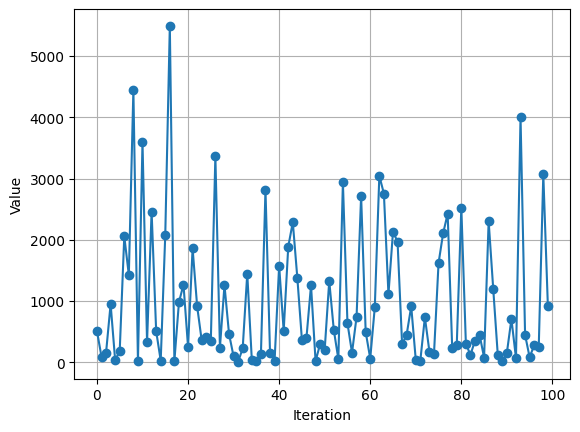

In [26]:
import matplotlib.pyplot as plt


plt.figure()
plt.plot(loss_h_mcar30, marker='o')
        #plt.title(f"Changes for imps[{index[0]}, {index[1]}]")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.grid(True)
plt.show()


In [27]:
#Loss Calculation 30% sk_imps_mar

batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_imp_mar30 = pick_epsilon(sk_imp_mar30)
print(epsilon_imp_mar30)

loss_mar30 = Loss_Calculation(eps=epsilon_imp_mar30, batchsize=batchsize, lr=lr, niter=100)
loss_h_mar30= loss_mar30.transform(sk_imp_mar30, verbose=True, report_interval=500)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 63.0018


63.00181895434438
[ 19  45 140  30  67  16 119 174 109 141  24 150  41 118  15 111 113  82
   9 114  18  66  60 169 171 164 117  65  90  55  29 128 145  31  12  42
 158 137  98 159  38 108  85  68 143   2 100 122 154  51  76  56  26 153
 138 104  78  36  93  22 146  97  69 167]
[152 145 109  76 114  12  42  99  62  25 177  14 166  63 106  84 148 147
  57   9  82 101  48 137 155 133 105  94  46  72 144 124 108   5  28 118
  43 153  78   3 172   4 143  27  64  55  87  33 116  26 174  77  44 162
  85  29  45 107  54  21 169 167 141  70]
loss tensor(2509.7883)
[157 168  55  37  70  43  44  81  13 162 116  76  80  24 136 159 131  10
  78  17  20 164   6 133  67 166 121  40  86  41 140 111 119  73  87 138
  30  45 150  84  71 127  58 156   2 139  36  42 144  74  34 173 137 135
 165  26 155  27 145   1 160  96  23  83]
[120  33 152  45  40 117  81  54  50  34 130 167  78  21 163  39 176   1
  84 126 109 145  79  67  63 125  49  47  96 156  92 102 135 147 129 137
 124 101  42  77  25 114 134 1

In [28]:
#Loss Calculation 30% mar

batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_imp_mar30 = pick_epsilon(data_mar30)

loss_withoi_mar30 = Loss_Calculation(eps=epsilon_imp_mar30, batchsize=batchsize, lr=lr, niter=100)
loss_wi_mar30 = loss_withoi_mar30.transform(data_mar30, verbose=True, report_interval=500)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 65.3869


[ 19  45 140  30  67  16 119 174 109 141  24 150  41 118  15 111 113  82
   9 114  18  66  60 169 171 164 117  65  90  55  29 128 145  31  12  42
 158 137  98 159  38 108  85  68 143   2 100 122 154  51  76  56  26 153
 138 104  78  36  93  22 146  97  69 167]
[152 145 109  76 114  12  42  99  62  25 177  14 166  63 106  84 148 147
  57   9  82 101  48 137 155 133 105  94  46  72 144 124 108   5  28 118
  43 153  78   3 172   4 143  27  64  55  87  33 116  26 174  77  44 162
  85  29  45 107  54  21 169 167 141  70]
loss tensor(2494.2093)
[157 168  55  37  70  43  44  81  13 162 116  76  80  24 136 159 131  10
  78  17  20 164   6 133  67 166 121  40  86  41 140 111 119  73  87 138
  30  45 150  84  71 127  58 156   2 139  36  42 144  74  34 173 137 135
 165  26 155  27 145   1 160  96  23  83]
[120  33 152  45  40 117  81  54  50  34 130 167  78  21 163  39 176   1
  84 126 109 145  79  67  63 125  49  47  96 156  92 102 135 147 129 137
 124 101  42  77  25 114 134 118 153  23  59  80

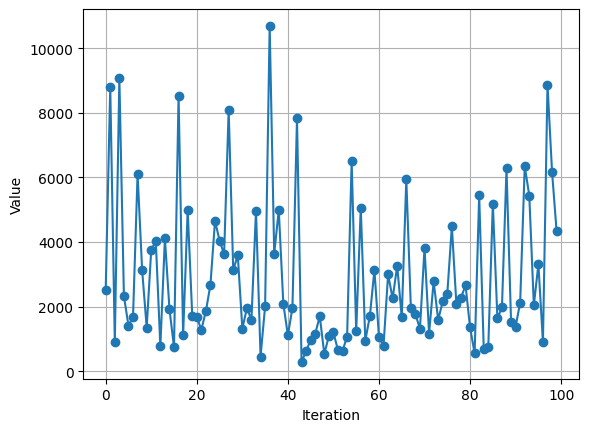

In [29]:
import matplotlib.pyplot as plt


plt.figure()
plt.plot(loss_h_mar30, marker='o')
        #plt.title(f"Changes for imps[{index[0]}, {index[1]}]")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.grid(True)
plt.show()

In [30]:
#Loss Calculation 30% mnar

batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_imp_mnar30 = pick_epsilon(sk_imp_mnar30)


loss_mnar30 = Loss_Calculation(eps=epsilon_imp_mnar30, batchsize=batchsize, lr=lr, niter=100)
loss_h_mnar30= loss_mnar30.transform(sk_imp_mnar30, verbose=True, report_interval=500)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 1990.5076


[ 19  45 140  30  67  16 119 174 109 141  24 150  41 118  15 111 113  82
   9 114  18  66  60 169 171 164 117  65  90  55  29 128 145  31  12  42
 158 137  98 159  38 108  85  68 143   2 100 122 154  51  76  56  26 153
 138 104  78  36  93  22 146  97  69 167]
[152 145 109  76 114  12  42  99  62  25 177  14 166  63 106  84 148 147
  57   9  82 101  48 137 155 133 105  94  46  72 144 124 108   5  28 118
  43 153  78   3 172   4 143  27  64  55  87  33 116  26 174  77  44 162
  85  29  45 107  54  21 169 167 141  70]
loss tensor(10.5311)
[157 168  55  37  70  43  44  81  13 162 116  76  80  24 136 159 131  10
  78  17  20 164   6 133  67 166 121  40  86  41 140 111 119  73  87 138
  30  45 150  84  71 127  58 156   2 139  36  42 144  74  34 173 137 135
 165  26 155  27 145   1 160  96  23  83]
[120  33 152  45  40 117  81  54  50  34 130 167  78  21 163  39 176   1
  84 126 109 145  79  67  63 125  49  47  96 156  92 102 135 147 129 137
 124 101  42  77  25 114 134 118 153  23  59  80 1

In [31]:
#Loss Calculation 30% mnar

batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_imp_mnar30 = pick_epsilon(data_mnar30)

loss_withoi_mnar30 = Loss_Calculation(eps=epsilon_imp_mnar30, batchsize=batchsize, lr=lr, niter=100)
loss_wi_mnar30 = loss_withoi_mnar30.transform(data_mnar30, verbose=True, report_interval=500)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 1990.5617


[ 19  45 140  30  67  16 119 174 109 141  24 150  41 118  15 111 113  82
   9 114  18  66  60 169 171 164 117  65  90  55  29 128 145  31  12  42
 158 137  98 159  38 108  85  68 143   2 100 122 154  51  76  56  26 153
 138 104  78  36  93  22 146  97  69 167]
[152 145 109  76 114  12  42  99  62  25 177  14 166  63 106  84 148 147
  57   9  82 101  48 137 155 133 105  94  46  72 144 124 108   5  28 118
  43 153  78   3 172   4 143  27  64  55  87  33 116  26 174  77  44 162
  85  29  45 107  54  21 169 167 141  70]
loss tensor(10.5326)
[157 168  55  37  70  43  44  81  13 162 116  76  80  24 136 159 131  10
  78  17  20 164   6 133  67 166 121  40  86  41 140 111 119  73  87 138
  30  45 150  84  71 127  58 156   2 139  36  42 144  74  34 173 137 135
 165  26 155  27 145   1 160  96  23  83]
[120  33 152  45  40 117  81  54  50  34 130 167  78  21 163  39 176   1
  84 126 109 145  79  67  63 125  49  47  96 156  92 102 135 147 129 137
 124 101  42  77  25 114 134 118 153  23  59  80 1

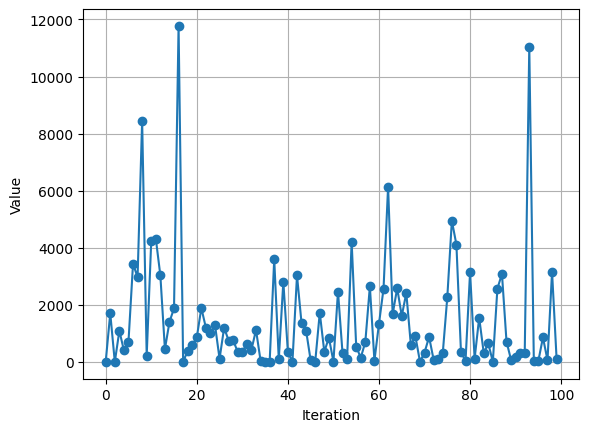

In [32]:
import matplotlib.pyplot as plt


plt.figure()
plt.plot(loss_h_mnar30, marker='o')
        #plt.title(f"Changes for imps[{index[0]}, {index[1]}]")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.grid(True)
plt.show()

In [33]:
print(loss_h_mcar30)
print(loss_wi_mcar30)
print(loss_h_mar30)
print(loss_wi_mar30)
print(loss_h_mnar30)
print(loss_wi_mnar30)

[510.9355189540056, 90.64904363050255, 155.16114131495374, 949.3970989919317, 31.28602050909558, 188.53215666459073, 2057.5606416372175, 1425.0309909854795, 4446.477468406294, 19.086657628276498, 3594.940181014752, 327.7183523758349, 2461.811175868009, 509.13881209144347, 27.790856109737888, 2082.9550479010063, 5492.87437152925, 17.42629698494602, 979.2772648760736, 1269.0177922107387, 250.66635699027847, 1860.3644780592508, 913.1672288958883, 356.5977861896131, 414.1264693885114, 345.56329749610586, 3365.753535650627, 239.98965309812164, 1258.6942725869583, 462.4178040757279, 95.14500924604363, 5.6472497134588195, 228.82679017397277, 1447.8206110066458, 41.20348929774946, 17.11648961253968, 129.65113131309926, 2815.8861764216417, 155.47328119430176, 23.2491654106079, 1575.9955652045176, 512.4258106190953, 1888.048181849771, 2287.084367492367, 1374.0727450291688, 367.4782828358557, 400.9937344441837, 1256.5408238560462, 17.025288584886425, 299.4770058642962, 200.0742977485595, 1329.441

In [34]:
changed_values_mcar30 = abs(sk_imp_mcar30_mean - sk_imp_mcar30)
print(abs(sk_imp_mcar30_mean - sk_imp_mcar30))

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0303, 0.0000, 0.0000],
        [0.0569, 0.5676, 0.0450,  ..., 0.0000, 0.0000, 0.0000],
        [0.1657, 0.0000, 0.0000,  ..., 0.0000, 0.0950, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0224, 0.0000, 0.0000],
        [0.0000, 0.1016, 0.0000,  ..., 0.2511, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0029,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<AbsBackward0>)


In [35]:
import torch

# Example tensor


# Calculate the sum of non-zero values for each column
non_zero_sums = changed_values_mcar30.where(changed_values_mcar30> 0, torch.tensor(0.0)).sum(dim=0)
#print(non_zero_sums)

# Calculate the count of non-zero values for each column
non_zero_counts = (changed_values_mcar30 > 0).sum(dim=0)
#print(non_zero_counts)

# Calculate the average of non-zero values for each column
non_zero_averages = (non_zero_sums / non_zero_counts)*100
non_zero_averages[non_zero_counts == 0] = 0  # Handle columns with no non-zero values

# Display the results
print("Column-wise Average of Non-Zero Values:")
for col_idx, avg in enumerate(non_zero_averages):
    print(f"Column {col_idx}: {avg:.4f}")


Column-wise Average of Non-Zero Values:
Column 0: 18.9365
Column 1: 21.8513
Column 2: 12.4806
Column 3: 29.2983
Column 4: 36.8605
Column 5: 19.1593
Column 6: 21.3935
Column 7: 10.0493
Column 8: 14.7957
Column 9: 25.9524
Column 10: 10.6746
Column 11: 16.0728
Column 12: 35.8324


In [36]:
changed_values_mar30 = abs(sk_imp_mar30_mean - sk_imp_mar30)
print(abs(sk_imp_mar30_mean - sk_imp_mar30))

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.2294, 0.0000, 2.3858],
        [0.0000, 0.0000, 0.0000,  ..., 0.1052, 0.0000, 1.8675],
        [0.0000, 0.0000, 0.0000,  ..., 0.0217, 0.0000, 2.3271],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.2412, 0.0000, 2.3642],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.7129],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.3300]],
       grad_fn=<AbsBackward0>)


In [37]:
import torch

# Example tensor


# Calculate the sum of non-zero values for each column
non_zero_sums = changed_values_mar30.where(changed_values_mar30> 0, torch.tensor(0.0)).sum(dim=0)
#print(non_zero_sums)

# Calculate the count of non-zero values for each column
non_zero_counts = (changed_values_mar30 > 0).sum(dim=0)
#print(non_zero_counts)

# Calculate the average of non-zero values for each column
non_zero_averages = (non_zero_sums / non_zero_counts)*100
non_zero_averages[non_zero_counts == 0] = 0  # Handle columns with no non-zero values

# Display the results
print("Column-wise Average of Non-Zero Values:")
for col_idx, avg in enumerate(non_zero_averages):
    print(f"Column {col_idx}: {avg:.4f}")


Column-wise Average of Non-Zero Values:
Column 0: 0.0000
Column 1: 0.0000
Column 2: 0.0000
Column 3: 39.0850
Column 4: 102.9658
Column 5: 0.0000
Column 6: 24.7404
Column 7: 8.8121
Column 8: 0.0000
Column 9: 0.0000
Column 10: 13.4393
Column 11: 0.0000
Column 12: 190.4776


In [38]:
changed_values_mnar30 = abs(sk_imp_mnar30_mean - sk_imp_mnar30)
print(abs(sk_imp_mnar30_mean - sk_imp_mnar30))

tensor([[0.0259, 0.0000, 0.0829,  ..., 0.0000, 0.3555, 0.0000],
        [0.3540, 0.0000, 0.3047,  ..., 0.0000, 0.0000, 0.0000],
        [0.1693, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0291, 0.0000, 0.2413,  ..., 0.0000, 0.2165, 0.0000],
        [0.0000, 0.0000, 0.0980,  ..., 0.0000, 0.0026, 0.0000],
        [0.0000, 0.0000, 0.1664,  ..., 0.0000, 0.3595, 0.0000]],
       grad_fn=<AbsBackward0>)


In [39]:
import torch

# Example tensor


# Calculate the sum of non-zero values for each column
non_zero_sums = changed_values_mnar30.where(changed_values_mnar30> 0, torch.tensor(0.0)).sum(dim=0)
#print(non_zero_sums)

# Calculate the count of non-zero values for each column
non_zero_counts = (changed_values_mnar30 > 0).sum(dim=0)
#print(non_zero_counts)

# Calculate the average of non-zero values for each column
non_zero_averages = (non_zero_sums / non_zero_counts)*100
non_zero_averages[non_zero_counts == 0] = 0  # Handle columns with no non-zero values

# Display the results
print("Column-wise Average of Non-Zero Values:")
for col_idx, avg in enumerate(non_zero_averages):
    print(f"Column {col_idx}: {avg:.4f}")


Column-wise Average of Non-Zero Values:
Column 0: 15.3032
Column 1: 0.0000
Column 2: 12.5012
Column 3: 0.0000
Column 4: 0.0000
Column 5: 14.1643
Column 6: 0.0000
Column 7: 0.0000
Column 8: 13.7155
Column 9: 24.2933
Column 10: 0.0000
Column 11: 15.4244
Column 12: 0.0000


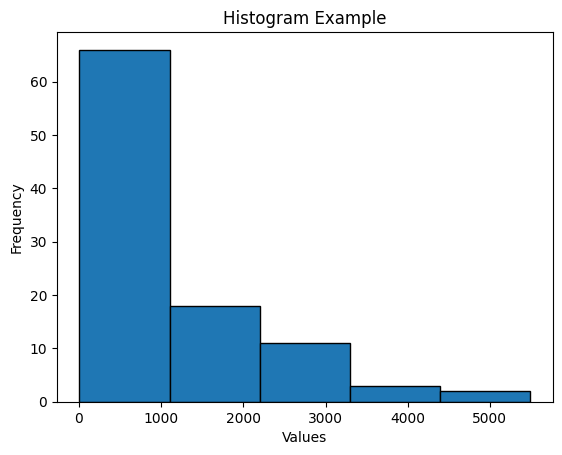

In [40]:
plt.hist(loss_h_mcar30, bins=5, edgecolor='black')  # bins: number of bins for grouping data
plt.title('Histogram Example')  # Title of the plot
plt.xlabel('Values')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.show()

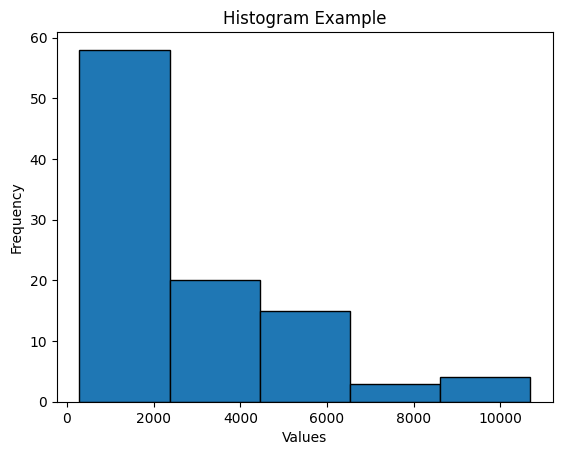

In [41]:
plt.hist(loss_h_mar30, bins=5, edgecolor='black')  # bins: number of bins for grouping data
plt.title('Histogram Example')  # Title of the plot
plt.xlabel('Values')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.show()

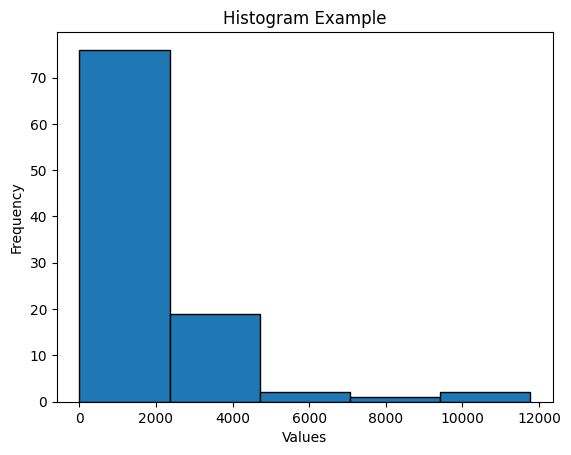

In [42]:
plt.hist(loss_h_mnar30, bins=5, edgecolor='black')  # bins: number of bins for grouping data
plt.title('Histogram Example')  # Title of the plot
plt.xlabel('Values')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.show()

C:\Users\zhossai3\AppData\Local\Temp\ipykernel_18144\196198122.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(loss_h_mcar30, shade=True)  # `shade=True` fills the area under the curve


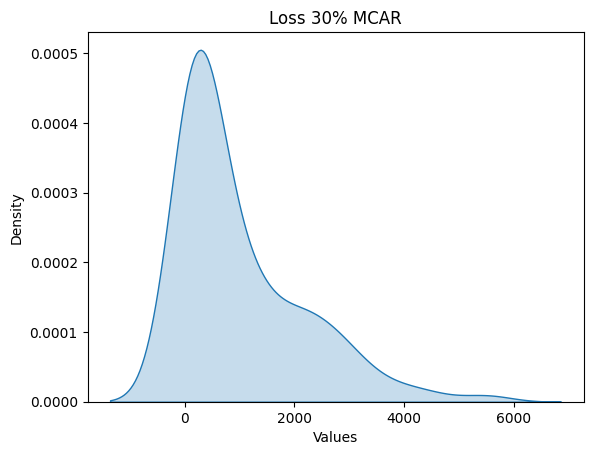

In [43]:
import seaborn as sns
sns.kdeplot(loss_h_mcar30, shade=True)  # `shade=True` fills the area under the curve
plt.title('Loss 30% MCAR')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

C:\Users\zhossai3\AppData\Local\Temp\ipykernel_18144\3095314945.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(loss_h_mar30, shade=True)  # `shade=True` fills the area under the curve


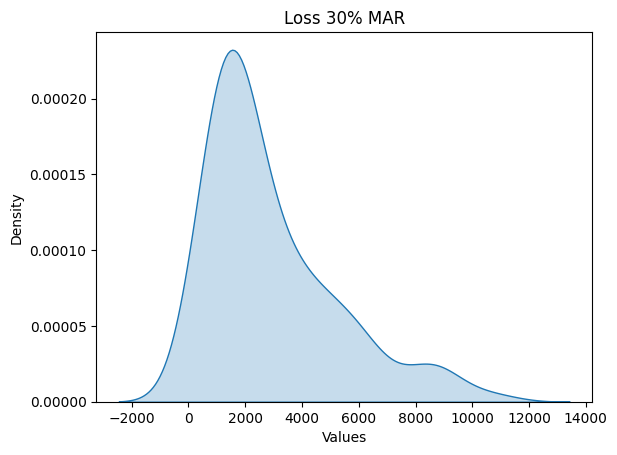

In [44]:
import seaborn as sns
sns.kdeplot(loss_h_mar30, shade=True)  # `shade=True` fills the area under the curve
plt.title('Loss 30% MAR')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

C:\Users\zhossai3\AppData\Local\Temp\ipykernel_18144\1174724183.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(loss_h_mnar30, shade=True)  # `shade=True` fills the area under the curve


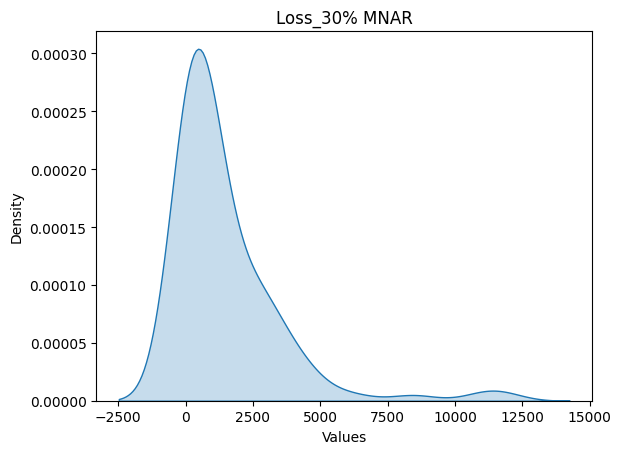

In [45]:
import seaborn as sns
sns.kdeplot(loss_h_mnar30, shade=True)  # `shade=True` fills the area under the curve
plt.title('Loss_30% MNAR')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

In [46]:
feature_names = [f'Feature{i+1}' for i in range(data_mar30.shape[1])]
data_mcar30_pd = pd.DataFrame(data_mar30.numpy(), columns=feature_names)
correlation_matrix_mcar30 = data_mcar30_pd.corr()


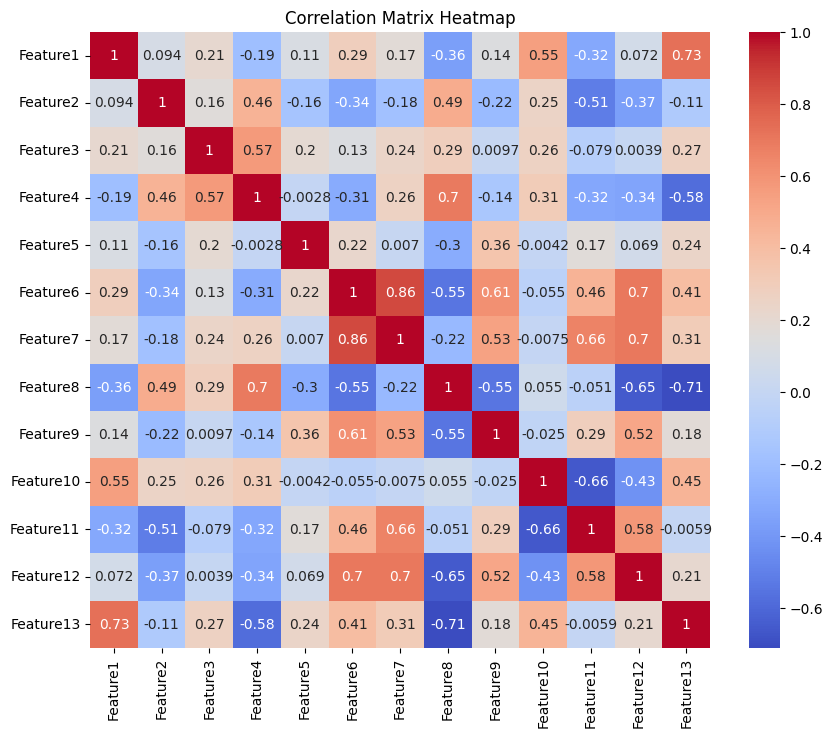

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_mcar30, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()
